In [156]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



### set-up

In [8]:
session = boto3.Session()
s3 = session.client('s3')

In [9]:
bucket_name = "cdo-ililapse-364524684987-bucket"
file_path = "x266754/lapse/"

## data from s3

In [10]:
file_name = "x266754/lapse/curated_features.parquet"

In [11]:
%%time
obj = s3.get_object(Bucket = bucket_name, Key = file_name)
df = pd.read_parquet(io.BytesIO(obj['Body'].read())) 

CPU times: user 36.8 s, sys: 15.7 s, total: 52.4 s
Wall time: 42.6 s


In [14]:
df.head()

,year,month,agmt_pkge_id,vul,ul,term,aos_status_code,val_inforce_cls,kind_code,sub_kind,...,reinstate,num_current_3m,num_lapse_3m,num_reinstate_3m,num_policies_hh,num_policies_hh_lag1,mom_hh_policies,num_sr_6m,holder_age_bucket,cash_val_bucket
0,2022,1,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"9. (60,65]",3. $25k-50k
1,2022,2,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0,2.0,0.0,0.0,1.0,1.0,0.0,4.0,"9. (60,65]",3. $25k-50k
2,2022,3,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0,3.0,0.0,0.0,1.0,1.0,0.0,5.0,"9. (60,65]",3. $25k-50k
3,2022,4,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0,3.0,0.0,0.0,1.0,1.0,0.0,5.0,"9. (60,65]",3. $25k-50k
4,2022,5,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0,3.0,0.0,0.0,1.0,1.0,0.0,5.0,"9. (60,65]",3. $25k-50k


### macro data

In [12]:
macro = pd.read_csv("macro_fred.csv")

In [16]:
macro['macro_cur_month'] = macro['macro_date'].astype('datetime64[ns]').map(lambda x: x.strftime('%Y-%m'))

In [122]:
colnames = macro.columns[macro.columns.str.contains(pat = 'per')]
for col in colnames:
    macro[col] = macro[col]*100

In [123]:
macro.head()

,macro_date,Unemp,ICSA,Dincome,PCE,CPI,Leading,CS_HPI,SP500,ICE_Corp,...,CPI_per,Leading_per,CS_HPI_per,SP500_per,ICE_Corp_chg,ICE_HY_chg,FF_chg,T3M_chg,T10Y2Y_chg,macro_cur_month
0,2018-01-01,4.0,223000,14173.9,109.080,248.743,100.481849,198.205,2789.80,0.95,...,0.378523,0.085278,0.566242,4.708982,-0.06,-0.07,0.11,0.09,-0.01,2018-01
1,2018-02-01,4.1,202000,14198.4,109.311,249.439,100.568719,199.146,2705.16,0.97,...,0.279807,0.086454,0.474761,-3.034211,0.02,0.43,0.01,0.16,0.13,2018-02
2,2018-03-01,4.0,205000,14242.1,109.562,249.581,100.630686,199.967,2702.77,1.10,...,0.056928,0.061617,0.412260,-0.088034,0.13,0.12,0.09,0.13,-0.12,2018-03
3,2018-04-01,4.0,200000,14275.9,109.750,250.146,100.658115,200.781,2653.63,1.12,...,0.226379,0.027257,0.407067,-1.818449,0.02,-0.10,0.18,0.06,-0.08,2018-04
4,2018-05-01,3.8,224000,14320.7,109.956,250.779,100.657423,201.624,2701.49,1.16,...,0.253052,-0.000688,0.419860,1.803887,0.03,0.11,0.01,0.10,-0.02,2018-05


### merge

In [125]:
%%time
df=df.merge(macro, how='left', 
              left_on=['pfmc_cur_month'], 
              right_on = ['macro_cur_month'],
              suffixes=('', '_remove'))

CPU times: user 6.91 s, sys: 4.17 s, total: 11.1 s
Wall time: 11.1 s


In [127]:
df.head()

,year,month,agmt_pkge_id,vul,ul,term,aos_status_code,val_inforce_cls,kind_code,sub_kind,...,CPI_per_remove,Leading_per_remove,CS_HPI_per_remove,SP500_per_remove,ICE_Corp_chg_remove,ICE_HY_chg_remove,FF_chg_remove,T3M_chg_remove,T10Y2Y_chg_remove,macro_cur_month_remove
0,2022,1,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0.645067,-0.121345,1.571622,-2.159618,-0.01,0.25,0.00,0.09,0.00,2022-01
1,2022,2,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0.797707,-0.166382,1.939835,-3.013567,0.16,0.69,0.00,0.18,-0.28,2022-02
2,2022,3,344785920000,YES,NaN,NaN,B,PP,01479,B,...,1.240754,-0.213473,2.091320,-1.008014,0.22,0.43,0.12,0.11,-0.28,2022-03
3,2022,4,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0.331934,-0.252059,1.656124,0.000701,-0.09,0.50,0.13,0.32,-0.01,2022-04
4,2022,5,344785920000,YES,NaN,NaN,B,PP,01479,B,...,0.973800,-0.280028,1.323492,-7.991627,0.18,0.95,0.44,0.22,0.07,2022-05


### group by lapse rate

In [128]:
g1 = df.groupby(['macro_cur_month'])['3mo_ahead_Lapse'].sum()
g2 = df.groupby(['macro_cur_month'])['3mo_ahead_Lapse'].count()
g = pd.concat([g1, g2],axis=1)
g.columns = ['lapse_cnt', 'total_cnt']
g['monthly_lapsed_rate']=g['lapse_cnt']/g['total_cnt']
g['annual_lapsed_rate'] = (1- (1-g['monthly_lapsed_rate'])**12)*100
g=g.sort_values('macro_cur_month')
g =g.merge(macro, how='left', 
              left_on=['macro_cur_month'], 
              right_on = ['macro_cur_month'])
g.set_index('macro_cur_month', inplace = True)
g.head()

,lapse_cnt,total_cnt,monthly_lapsed_rate,annual_lapsed_rate,macro_date,Unemp,ICSA,Dincome,PCE,CPI,...,PCE_per,CPI_per,Leading_per,CS_HPI_per,SP500_per,ICE_Corp_chg,ICE_HY_chg,FF_chg,T3M_chg,T10Y2Y_chg
macro_cur_month,,,,,,,,,,,,,,,,,,,,,
2022-01,1635,729829,0.002240,2.655423,2022-01-01,4.0,214000,15137.7,120.761,281.933,...,0.472573,0.645067,-0.121345,1.571622,-2.159618,-0.01,0.25,0.00,0.09,0.00
2022-02,1902,728132,0.002612,3.089952,2022-02-01,3.8,182000,15125.6,121.205,284.182,...,0.367668,0.797707,-0.166382,1.939835,-3.013567,0.16,0.69,0.00,0.18,-0.28
2022-03,2083,722865,0.002882,3.403627,2022-03-01,3.6,171000,15064.1,121.651,287.708,...,0.367972,1.240754,-0.213473,2.091320,-1.008014,0.22,0.43,0.12,0.11,-0.28
2022-04,2076,718531,0.002889,3.412507,2022-04-01,3.6,202000,15055.2,122.030,288.663,...,0.311547,0.331934,-0.252059,1.656124,0.000701,-0.09,0.50,0.13,0.32,-0.01
2022-05,2383,726241,0.003281,3.867247,2022-05-01,3.6,202000,15036.4,122.488,291.474,...,0.375318,0.973800,-0.280028,1.323492,-7.991627,0.18,0.95,0.44,0.22,0.07


### correlation plot

In [129]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [130]:
corr_df = g[[ 'annual_lapsed_rate',
              'Unemp',
            'ICSA',
            'Dincome',
            'PCE',
            'CPI',
            'Leading',
            'CS_HPI',
            'SP500',
            'ICE_Corp',
            'ICE_HY',
            'FF',
            'T3M',
            'T10Y2Y',
            'Unemp_chg',
            'ICSA_per',
            'Dincome_per',
            'PCE_per',
            'CPI_per',
            'Leading_per',
            'CS_HPI_per',
            'SP500_per',
            'ICE_Corp_chg',
            'ICE_HY_chg',
            'FF_chg',
            'T3M_chg',
            'T10Y2Y_chg'
]]

corr = corr_df.corr()

# plt.figure(figsize=(10, 10))
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

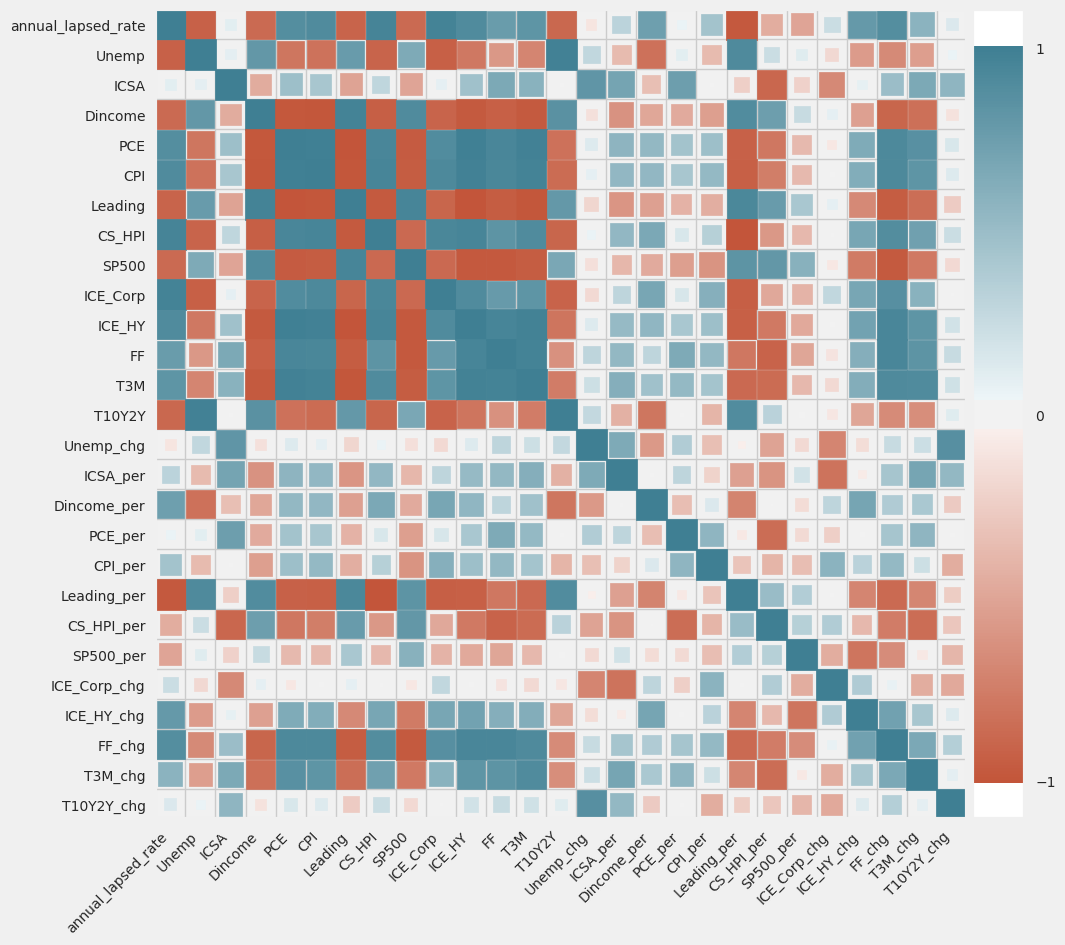

In [248]:
# good economy,  lower lapse
plt.figure(figsize=(10, 10))
corrplot(corr)
plt.show()

#### Lapse Rate 

In [249]:
def macro_plot_v1(macro_col, title):
    plt_df = g[['annual_lapsed_rate', macro_col]]
    cols = [col for col in plt_df.columns][0:2]
    print(cols)

    fig, ax = plt.subplots(1, 1, figsize=(8,6))

    plt.style.use('fivethirtyeight')
    colors = [ 'b','g:', 'r--']

    i=0
    for c in cols:
        i = i +1 
        plt.figure
        ax.plot(c,  colors[(i-1)], data=plt_df)
        ax.set_title(title,fontsize = 11)

        plt.xlabel('yyyy-mm')
        plt.xticks(rotation = 45)
        plt.ylabel('Lapse Rate')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels,loc='lower right', prop={"size":10})

    plt.show()

In [268]:
def macro_plot_v2(macro_col, title):
    plt_df = g[['annual_lapsed_rate', macro_col]]

    cols = [col for col in plt_df.columns][0:2]
    print(cols)

    fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

    color = 'b'
    ax1.set_xlabel('yyyy-mm',fontsize = 11)

    ax1.set_ylabel('Lapse Rate',fontsize = 11)
    ax1.plot('annual_lapsed_rate', data =plt_df, color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(title,fontsize = 11)

    ax2 = ax1.twinx()  

    color = 'g'
    ax2.set_ylabel(macro_col,fontsize = 11) 
    ax2.grid(False)
    ax2.plot(macro_col, '--',  color = color,   data =plt_df)
    ax2.tick_params(axis='y', labelcolor=color)
    handles, labels = ax2.get_legend_handles_labels()
    ax1.legend(handles, labels,loc='lower right', prop={"size":10})
    fig.tight_layout()  
    plt.show()

['annual_lapsed_rate', 'Unemp']


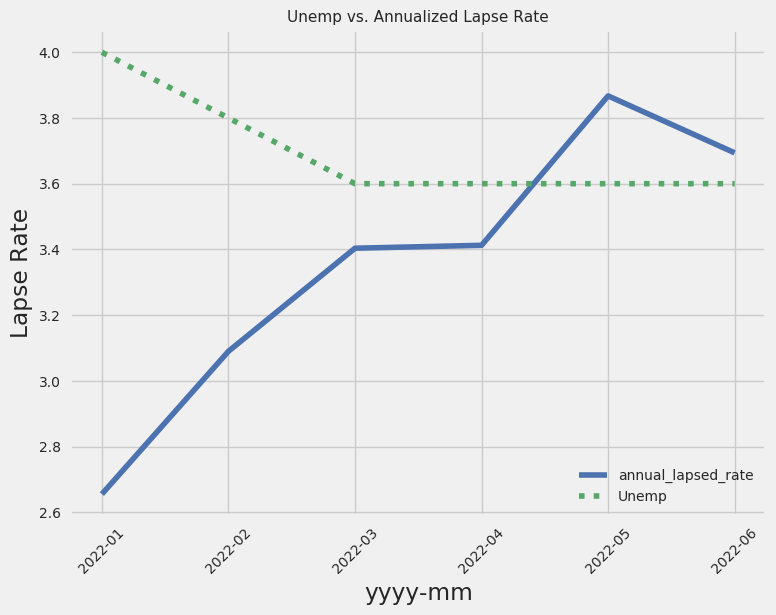

In [252]:
macro_plot_v1('Unemp', 'Unemp vs. Annualized Lapse Rate')

['annual_lapsed_rate', 'Unemp_chg']


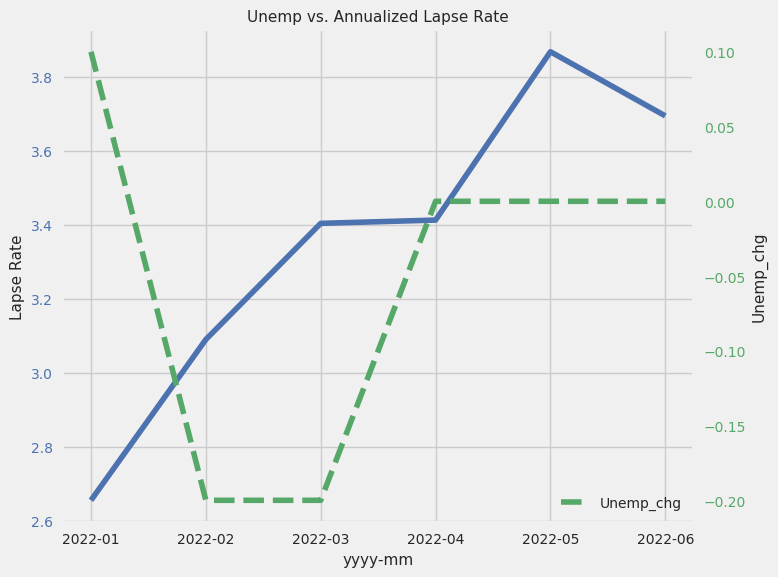

In [270]:
macro_plot_v2('Unemp_chg', 'Unemp vs. Annualized Lapse Rate')

['annual_lapsed_rate', 'Leading_per']


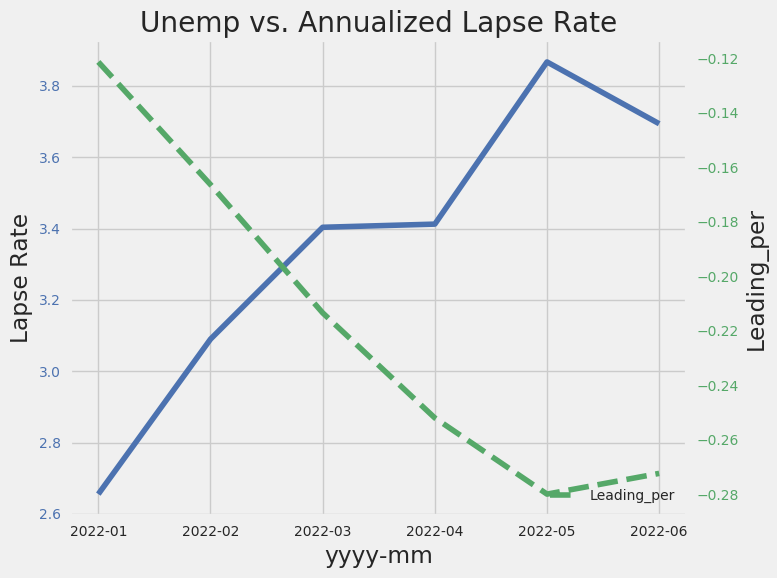

In [247]:
macro_plot_v2('Leading_per', 'Unemp vs. Annualized Lapse Rate')

['annual_lapsed_rate', 'ICSA_per']


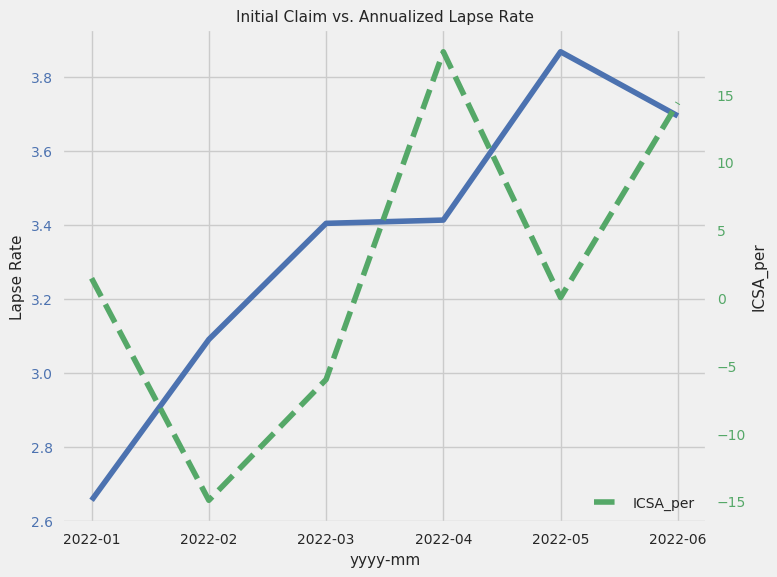

In [271]:
macro_plot_v2('ICSA_per', 'Initial Claim vs. Annualized Lapse Rate')

['annual_lapsed_rate', 'Dincome_per']


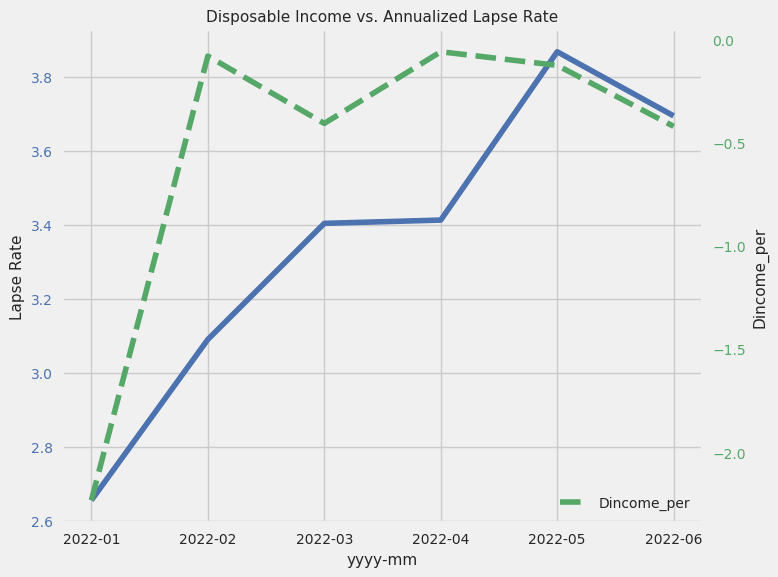

In [273]:
macro_plot_v2('Dincome_per', 'Disposable Income vs. Annualized Lapse Rate')

['annual_lapsed_rate', 'PCE_per']


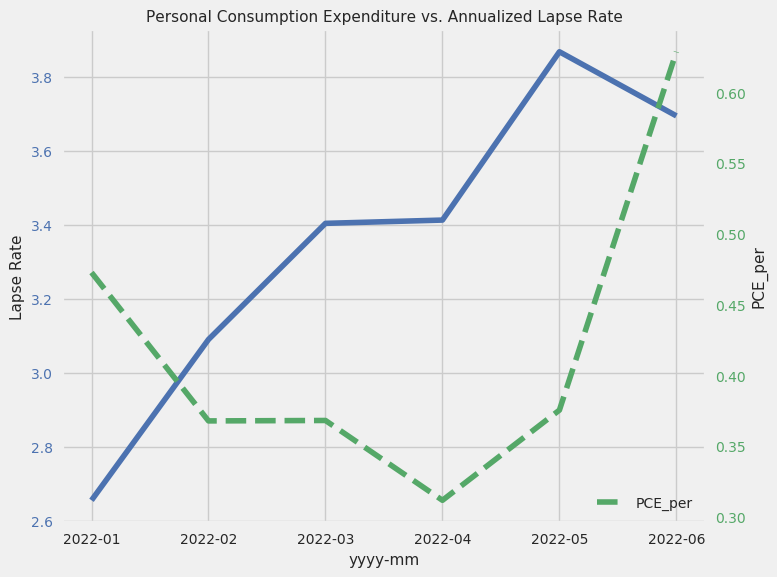

In [272]:
macro_plot_v2('PCE_per', 'Personal Consumption Expenditure vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('CPI_per', 'CPI vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('Leading_per', 'OECD: US Leading Indicator vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('CS_HPI_per', 'Case-Shiller HPI vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('SP500_per', 'SP 500 vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('ICE_Corp_chg', 'ICE Bofa Corp Bond Yield Change vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('ICE_HY_chg', 'ICE Bofa HY Bond Yield Change vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('T3M_chg', '3month T-Bill Change vs. Annualized Lapse Rate')

In [ ]:
macro_plot_v2('T10Y2Y_chg', 'T10Y2Y_chg vs. Annualized Lapse Rate')